In [ ]:
import os
import shutil
import subprocess
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain.tools import tool
from langchain_core.tools import tool
from langchain_core.tools.simple import Tool
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain.schema.language_model import BaseLanguageModel
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_core.output_parsers import PydanticToolsParser
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
import warnings
warnings.filterwarnings('ignore')

os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY"
os.environ["GROQ_API_KEY"] = "YOUR_API_KEY"
os.environ["ANTHROPIC_API_KEY"]="YOUR_API_KEY"

In [60]:
import operator
import traceback
import typing as t
from typing import Annotated, Literal, Sequence

import dotenv
# from langchain_aws import ChatBedrock
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode

In [61]:
import os
import json
from pprint import pprint
import ast
# from get_repo_structure.get_repo_structure import get_project_structure_from_scratch
# PROJECT_FILE_LOC = os.environ.get("PROJECT_FILE_LOC", None)
# print(PROJECT_FILE_LOC)

def get_docstring(node):
    """Extract docstring from AST node if it exists."""
    if (
        node.body 
        and isinstance(node.body[0], ast.Expr) 
        and isinstance(node.body[0].value, ast.Str)
    ):
        return node.body[0].value.s
    return None


def get_function_signature(node):
    """Extract function signature from AST node."""
    args_list = []
    
    # Get positional args
    for arg in node.args.posonlyargs:
        args_list.append(arg.arg)
        
    # Get regular args
    for arg in node.args.args:
        args_list.append(arg.arg)
        
    # Get args with defaults
    defaults = [None] * (len(node.args.args) - len(node.args.defaults)) + node.args.defaults
    for arg, default in zip(node.args.args, defaults):
        if default:
            try:
                default_value = ast.literal_eval(default)
                args_list.append(f"{arg.arg}={default_value}")
            except:
                args_list.append(f"{arg.arg}=...")

    # Get *args
    if node.args.vararg:
        args_list.append(f"*{node.args.vararg.arg}")

    # Get kwargs
    for kwarg in node.args.kwonlyargs:
        args_list.append(kwarg.arg)

    # Get **kwargs
    if node.args.kwarg:
        args_list.append(f"**{node.args.kwarg.arg}")
        
    docstring = get_docstring(node)
    signature = f"{node.name}({', '.join(args_list)})"
    
    if docstring:
        signature += f"\n    \"\"\"{docstring}\"\"\""
    
    return signature

def parse_python_file(file_path, file_content=None):
    """Parse a Python file to extract class and function definitions with their line numbers.
    :param file_path: Path to the Python file.
    :return: Class names, function names, and file contents
    """
    if file_content is None:
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                file_content = file.read()
                parsed_data = ast.parse(file_content)
        except Exception as e:  # Catch all types of exceptions
            print(f"Error in file {file_path}: {e}")
            return [], [], ""
    else:
        try:
            parsed_data = ast.parse(file_content)
        except Exception as e:  # Catch all types of exceptions
            print(f"Error in file {file_path}: {e}")
            return [], [], ""

    class_info = []
    function_names = []
    class_methods = set()

    for node in ast.walk(parsed_data):
        if isinstance(node, ast.ClassDef):
            methods = []
            for n in node.body:
                if isinstance(n, ast.FunctionDef):
                    methods.append(
                        {
                            "name": n.name,
                            "signature": "@classmethod\ndef " + get_function_signature(n),
                            "start_line": n.lineno,
                            "end_line": n.end_lineno,
                            "text": "\n".join(file_content.splitlines()[
                                n.lineno - 1 : n.end_lineno
                            ]),
                        }
                    )
                    class_methods.add(n.name)
            class_info.append(
                {
                    "name": node.name,
                    "start_line": node.lineno,
                    "end_line": node.end_lineno,
                    "text": "\n".join(file_content.splitlines()[
                        node.lineno - 1 : node.end_lineno
                    ]),
                    "methods": methods
                }
            )
        elif isinstance(node, ast.FunctionDef) and not isinstance(
            node, ast.AsyncFunctionDef
        ):
            if node.name not in class_methods:
                function_names.append(
                    {
                        "name": node.name,
                        "signature": get_function_signature(node),
                        "start_line": node.lineno,
                        "end_line": node.end_lineno,
                        "text": "\n".join(file_content.splitlines()[
                            node.lineno - 1 : node.end_lineno
                        ]),
                    }
                )

    return class_info, function_names, file_content.splitlines()

def create_structure(directory_path):
    """Create the structure of the repository directory by parsing Python files.
    :param directory_path: Path to the repository directory.
    :return: A dictionary representing the structure.
    """
    structure = {}

    for root, _, files in os.walk(directory_path):
        repo_name = os.path.basename(directory_path)
        # print("repo name", repo_name)
        relative_root = os.path.relpath(root, directory_path)
        if relative_root == ".":
            relative_root = repo_name
        curr_struct = structure
        for part in relative_root.split(os.sep):
            if part not in curr_struct:
                curr_struct[part] = {}
            curr_struct = curr_struct[part]
        for file_name in files:
            if file_name.endswith(".py"):
                file_path = os.path.join(root, file_name)
                class_info, function_names, file_lines = parse_python_file(file_path)
                curr_struct[file_name] = {
                    "classes": class_info,
                    "functions": function_names,
                    "text": file_lines,
                }
            else:
                curr_struct[file_name] = {}

    return structure

# structure = create_structure(r"D:\Projects\llmpairprog\Agentless\playground\588436a5-43f1-45f4-80b4-0394f1d7b838")
# print(structure['matplotlib']['setup.py'])

In [62]:
structure = create_structure(r'C:\Users\Sagnik1\Agentless')

In [63]:
@tool
def get_class_info(relative_file_path, class_name):
    """Search for a class by name in the given relative file path and return its details."""
    path_parts = relative_file_path.replace("\\", "/").split("/")  # Split into components
    current_level = structure  # Start traversing from the root of the structure
    # Traverse the structure using the normalized path
    for part in path_parts:
        if part in current_level:
            current_level = current_level[part]

    for clazz in current_level["classes"]:
        if clazz["name"] == class_name:
            return clazz['text']
    return None

def get_function_info(relative_file_path, function_name):
    """Search for a function or class method by name in the given relative file path and return its details."""
    path_parts = relative_file_path.replace("\\", "/").split("/")  # Split into components
    current_level = structure
    for part in path_parts:
        if part in current_level:
            current_level = current_level[part]

    for func in current_level["functions"]:
        if func["name"] == function_name:
            return func['text']
    for clazz in current_level["classes"]:
        for method in clazz["methods"]:
            if method["name"] == function_name:
                return method['text']
    return None


In [64]:
structure['get_repo_structure']['get_repo_structure.py']['functions']

[{'name': 'checkout_commit',
  'signature': 'checkout_commit(repo_path, commit_id)\n    """Checkout the specified commit in the given local git repository.\n    :param repo_path: Path to the local git repository\n    :param commit_id: Commit ID to checkout\n    :return: None\n    """',
  'start_line': 27,
  'end_line': 41,
  'text': 'def checkout_commit(repo_path, commit_id):\n    """Checkout the specified commit in the given local git repository.\n    :param repo_path: Path to the local git repository\n    :param commit_id: Commit ID to checkout\n    :return: None\n    """\n    try:\n        # Change directory to the provided repository path and checkout the specified commit\n        print(f"Checking out commit {commit_id} in repository at {repo_path}...")\n        subprocess.run(["git", "-C", repo_path, "checkout", commit_id], check=True)\n        print("Commit checked out successfully.")\n    except subprocess.CalledProcessError as e:\n        print(f"An error occurred while running

In [65]:
get_function_info(r'get_repo_structure/get_repo_structure.py', 'clone_repo')

'def clone_repo(repo_name, repo_playground):\n    try:\n\n        print(\n            f"Cloning repository from https://github.com/{repo_name}.git to {repo_playground}/{repo_to_top_folder[repo_name]}..."\n        )\n        subprocess.run(\n            [\n                "git",\n                "clone",\n                f"https://github.com/{repo_name}.git",\n                f"{repo_playground}/{repo_to_top_folder[repo_name]}",\n            ],\n            check=True,\n        )\n        print("Repository cloned successfully.")\n    except subprocess.CalledProcessError as e:\n        print(f"An error occurred while running git command: {e}")\n    except Exception as e:\n        print(f"An unexpected error occurred: {e}")'

In [66]:
import re

def format_class_and_function_info(info):
    """
    Format the class and function information as a string representation of the file content.
    
    :param info: dict, The dictionary containing class and function information for a file
    :return: str, Formatted string representation of the class and function structure with line numbers
    """
    result = []

    # Format classes
    if 'classes' in info:
        for cls in info['classes']:
            result.append(f"class {cls['name']} (Lines {cls['start_line']}-{cls['end_line']}):")
            for method in cls.get('methods', []):
                result.append(f"    {method['signature']} (Lines {method['start_line']}-{method['end_line']}):")

    # Format functions
    if 'functions' in info:
        result.append("\n")
        for func in info['functions']:
            result.append(f"def {func['name']}{func['signature'][func['signature'].find('('):]} (Lines {func['start_line']}-{func['end_line']}) :")
            # result.append("\n")
    return "\n".join(result)

@tool
def get_class_and_function_info(relative_file_path : str):
    """
    Retrieves class and function info from the repo map for a given relative file path.
    
    :param relative_file_path: str, The relative file path to look up in the structure
    :return: dict, Information about the file's classes and functions, or None if not found
    """
    path_parts = relative_file_path.replace("\\", "/").split("/")  # Split into components

    current_level = structure

    # Traverse the structure using the normalized path
    for part in path_parts:
        if part in current_level:
            current_level = current_level[part]
        else:
            return None  # Return None if any part is not found

    return format_class_and_function_info(current_level)  # Return the final value if traversal is successful


In [67]:
get_class_and_function_info(r'get_repo_structure/testing.py')

'\n\ndef commit_repo(commit_message)\n    """\n    Executes a git commit with the provided commit message.\n    \n    Args:\n        commit_message (str): The message to be used for the git commit\n        \n    Returns:\n        None\n    """ (Lines 3-19) :'

In [68]:
import subprocess
import os

@tool
def get_repo_tree(repo_path: str = None) -> str:
    """
    Generates and returns the repository directory tree.

    Args:
        repo_path (str, optional): Path to the repository.
                                   If None, uses the current working directory.

    Returns:
        str: The repository tree or an error message.
    """
    try:
        repo_path = r'C:\Users\Sagnik1\Agentless'
        tree = []
        
        for dirpath, dirnames, filenames in os.walk(repo_path):
            # Skip hidden directories and their contents
            dirnames[:] = [d for d in dirnames if not d.startswith('.')]
            
            # Get relative path
            rel_path = os.path.relpath(dirpath, repo_path)
            if rel_path != '.':
                tree.append(rel_path)
            # print(tree)
            # Add files
            for file in filenames:
                if not file.startswith('.'):
                    tree.append(os.path.join(rel_path, file))
                    
        # Sort and join paths
        return '\n'.join(sorted(tree))
        
    except Exception as e:
        return f"Error accessing directory '{repo_path}': {str(e)}"

# Example Usage
# print(get_tree())  # Runs in the current directory


In [69]:
def get_file_contents_with_line_numbers(file_path):
    """
    Open a file and return its contents as a single string with line numbers.
    
    :param file_path: str, Path to the file
    :return: str, File content with each line prefixed by its line number
    """
    try:
        with open(file_path, "r") as file:
            lines_with_numbers = [
                f"{line_no:2d}: {line.rstrip()}" for line_no, line in enumerate(file, start=1)
            ]
        return "\n".join(lines_with_numbers)
    except FileNotFoundError:
        return f"Error: The file at {file_path} was not found."
    except Exception as e:
        return f"An error occurred: {e}"


# file_path = r"D:\Projects\Agentless\agentless\fl\Index.py"
# print(get_file_contents_with_line_numbers(file_path))

In [70]:
from pathlib import Path
import re

def apply_edit(path, diff_text, fence=("<<<<<<< SEARCH", ">>>>>>> REPLACE")):
    file_path = Path(path)

    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    content = file_path.read_text()

    # Extracting SEARCH and REPLACE sections
    pattern = re.compile(
        rf"{re.escape(fence[0])}\n(.?)\n=======\n(.?)\n{re.escape(fence[1])}", 
        re.DOTALL
    )
    matches = pattern.findall(diff_text)

    if not matches:
        raise ValueError(f"Invalid diff format or missing markers in {path}")

    for original, updated in matches:
        if original.strip() not in content:
            raise ValueError(f"Original block not found in {path}:\n{original}")
        content = content.replace(original, updated)

    file_path.write_text(content)
    print(f"Successfully updated {path}")

In [71]:
import os
from typing import Optional

@tool
def open_file(relative_file_path: str, line_number: Optional[int] = None) -> None:
    """Opens the file at the given path in the editor with each line prefixed by its line number."""
    print(f"Opening file: {relative_file_path}")
    root_file_path = os.path.abspath(relative_file_path)
    try:
        with open(root_file_path, "r") as file:
            lines_with_numbers = [
                f"{line_no:2d}: {line.rstrip()}" for line_no, line in enumerate(file, start=1)
            ]
        return "\n".join(lines_with_numbers)
    except FileNotFoundError:
        return f"Error: The file at {root_file_path} was not found."
    except Exception as e:
        return f"An error occurred: {e}"


@tool
def goto_line(line_number: int) -> None:
    """Moves the window to show the specified line number."""
    print(f"Moving to line {line_number}.")

@tool
def scroll_down() -> None:
    """Moves the window down by 100 lines."""
    print("Scrolling down by 100 lines.")

@tool
def scroll_up() -> None:
    """Moves the window up by 100 lines."""
    print("Scrolling up by 100 lines.")

@tool
def create_file(filename: str, content: str) -> None:
    """Creates and opens a new file with the given name and writes the provided content to it."""
    with open(filename, 'w') as file:
        file.write(content)
    print(f"File '{filename}' created and content written.")

@tool
def edit_file(start_line: int, end_line: int, content: str, filename: str) -> None:
    """
    Edit a file by replacing content between specified lines or adding new content.
    Handles various editing scenarios with robust line number and content management.
    
    Args:
        start_line (int): The line number where the edit should begin (1-based indexing)
                         - For in-file edits: The first line to be replaced
                         - For appending: If > file length, content will be appended
        end_line (int): The line number where the edit should end (1-based indexing)
                       - Must be >= start_line
                       - For single-line insertions: Set equal to start_line
                       - For appending: Ignored when start_line > file length
        content (str): The new content to insert or replace existing content with
                      - Preserves indentation based on surrounding code
                      - Supports both single and multi-line content
                      - Empty lines will be preserved without indentation
        filename (str): Absolute path to the file to edit
                       - Creates new file if it doesn't exist
                       - Supports both UTF-8 and system default encodings
    """
    if not os.path.exists(filename):
        # Create new file if it doesn't exist
        with open(filename, 'w') as file:
            file.write(content)
        print(f"Created new file '{filename}' with content")
        return

    # Read existing content    
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            lines = file.readlines()
    except UnicodeDecodeError:
        # Fallback to system default encoding if UTF-8 fails
        with open(filename, 'r') as file:
            lines = file.readlines()
            
    total_lines = len(lines)
    
    # Validate inputs
    if start_line < 1:
        print("Error: Start line must be positive")
        return
        
    # Handle empty files
    if total_lines == 0:
        with open(filename, 'w') as file:
            file.write(content + '\n')
        print(f"Added content to empty file '{filename}'")
        return

    # Split content into lines and preserve indentation
    content_lines = content.splitlines()
    
    # Determine indentation from first non-empty line of existing content
    existing_indent = ""
    for line in lines:
        if line.strip():
            existing_indent = line[:len(line) - len(line.lstrip())]
            break
            
    # Case 1: Append to end of file
    if start_line > total_lines:
        # Ensure there's a newline before appending
        if lines and not lines[-1].endswith('\n'):
            lines.append('\n')
            
        # Add content with proper indentation
        for line in content_lines:
            if line.strip():  # Only indent non-empty lines
                lines.append(existing_indent + line + '\n')
            else:
                lines.append('\n')
                
    # Case 2: Insert or replace within file
    else:
        # Adjust end_line if it exceeds file length
        end_line = min(end_line, total_lines)
        
        # Prepare content with proper indentation
        indented_content = []
        for line in content_lines:
            if line.strip():  # Only indent non-empty lines
                indented_content.append(existing_indent + line + '\n')
            else:
                indented_content.append('\n')
                
        # Replace the lines
        lines[start_line-1:end_line] = indented_content
        
    # Write back to file with error handling
    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.writelines(lines)
            
        if start_line > total_lines:
            print(f"Appended content to '{filename}'")
        else:
            print(f"Modified lines {start_line} to {end_line} in '{filename}'")
            
    except Exception as e:
        print(f"Error writing to file: {e}")

@tool
def search_dir(search_term: str, dir_path: str = './') -> None:
    """Searches for `search_term` in all files in the given directory."""
    for root, _, files in os.walk(dir_path):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'r', errors='ignore') as f:
                if search_term in f.read():
                    print(f"Found '{search_term}' in {file_path}")

@tool
def search_file(search_term: str, file_path: Optional[str] = None) -> None:
    """Searches for `search_term` in a specific file or current open file."""
    if not file_path:
        file_path = "current_open_file.txt"  # Replace with actual open file handling
    """
    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found.")
        return
    """
    with open(file_path, 'r', errors='ignore') as file:
        content = file.read()
    
    if search_term in content:
        print(f"Found '{search_term}' in {file_path}")
    else:
        print(f"'{search_term}' not found in {file_path}")

@tool
def find_file(file_name: str, dir_path: str = './') -> None:
    """Finds all files with the given name in the specified directory."""
    matches = []
    for root, _, files in os.walk(dir_path):
        if file_name in files:
            matches.append(os.path.join(root, file_name))
    
    if matches:
        print(f"Found {file_name} in:")
        for match in matches:
            print(match)
    else:
        print(f"File '{file_name}' not found in {dir_path}.")

@tool
def list_files(dir_path: str = './') -> None:
    """Lists all files in the given directory."""
    try:
        files = os.listdir(dir_path)
        print(f"Files in '{dir_path}':")
        for file in files:
            print(file)
    except FileNotFoundError:
        print(f"Error: Directory '{dir_path}' not found.")


In [72]:
open_file(r'get_repo_structure/get_patch_info.py')

Opening file: get_repo_structure/get_patch_info.py


' 1: import argparse\n 2: import json\n 3: import re\n 4: from collections import defaultdict\n 5: \n 6: \n 7: def parse_patch(patch):\n 8:     """\n 9:     Parse a git patch into a structured format.\n10: \n11:     Parameters:\n12:         patch (str): The git patch as a string.\n13: \n14:     Returns:\n15:         list: A list of dictionaries representing the file changes and hunks.\n16:     """\n17:     file_changes = []\n18:     current_file = None\n19:     current_hunk = None\n20:     deleted_lines = 0\n21: \n22:     patch_lines = patch.split("\\n")\n23:     for line in patch_lines:\n24:         if line.startswith("diff --git"):\n25:             # Reset for new files\n26:             if current_file:\n27:                 file_changes.append(current_file)\n28:             current_file = {"file": "", "hunks": []}\n29:         elif line.startswith("--- a/"):\n30:             pass\n31:         elif line.startswith("+++ b/"):\n32:             if current_file is not None:\n33:          

In [73]:
obtain_relevant_files_prompt = """
Please look through the following GitHub problem description and Repository structure and provide a list of files that one would need to edit to fix the problem.

### GitHub Problem Description ###
{problem_statement}

###

### Repository Structure ###
{structure}

###

Please only provide the full path and return at most 5 files.
The returned files should be separated by new lines ordered by most to least important and wrapped with ```
For example:
```
file1.py
file2.py
```
"""

In [74]:
@tool
def get_relevant_files(problem_statement : str, repo_path : str = None):
    """
    Retrieves a list of relevant files to edit based on the problem statement and repository structure.
    :param problem_statement: str, The GitHub problem description.
    :param repo_path: str, The path to the repository. If None, the current working directory is used.
    :return: str, The list of relevant files.
    """
    repo_path = repo_path or os.getcwd()
    git_root = subprocess.run(
        ["git", "-C", repo_path, "rev-parse", "--show-toplevel"],
        capture_output=True,
        text=True,
        check=True
    ).stdout.strip()

    # Get the repo tree
    result = subprocess.run(
        ["git", "-C", git_root, "ls-tree", "-r", "HEAD", "--name-only"],
        capture_output=True,
        text=True,
        check=True
    )
    structure =  result.stdout.strip()
    prompt = obtain_relevant_files_prompt.format(problem_statement=problem_statement, structure=structure)
    message = [
        ("human", prompt)
    ]
    llm1 = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
    response = llm1.invoke(input=message)
    return response.content
    

In [75]:
@tool
def generate_patch(problem_statement : str):
    """
    This tool generates a patch based on the problem statement.
    :param problem_statement: str, The GitHub problem description.
    :return: str, The generated patch.
    """
    prompt="""
    Generate a patch for the following problem statement:
    {problem_statement}
    Carefully analyse the problem statement, think for sometime and generate a patch that addresses the issue.
    """
    message = [
        ("human", prompt.format(problem_statement=problem_statement))
    ]
    llm1 = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
    response = llm1.invoke(input=message)
    return response.content

In [76]:
PLANNER_PROMPT = """
You are an autonomous Planner tasked with solving coding issues. Your role is to coordinate between code analysis and editing tasks. Follow these guidelines:
You have access to the following tools:
- get_repo_tree: Use this to view the repository structure.

Do the following steps in the same order:
1. Issue Understanding:
   - Carefully read and understand the given issue or bug report.
   - Form a hypothesis about the problem and potential solutions.
   - A workspace is initialized for you, and you will be working on workspace. 
   - The git repo is cloned in the path and you need to work in this directory.
   - MAKE SURE THE EXISTING FUNCTIONALITY ISN'T BROKEN BY SOLVING THE ISSUE, THAT IS, 
     THE SOLUTION SHOULD BE MINIMAL AND SHOULD NOT BREAK THE EXISTING FUNCTIONALITY.

2. Use the get_repo_tree tool to understand the file structure of the codebase.
   - You can access the repository tree using the get_repo_tree tool.
   - SINCE YOU ARE AT SOME PREVIOUS VERSION OF THE CODE, YOUR INFORMATION ABOUT THE CODEBASE IS OUTDATED, SO 
     YOU NEED TO UNDERSTAND THE CODEBASE FROM SCRATCH AGAIN.
   - This tool will only give you the directory structure, so if you need further analysis, always respond with "ANALYZE CODE".
   - Once you get the directory structure, use the 
   tool to generate a patch that addresses the issue.

3. Code Analysis:
   - When you need to understand the codebase or investigate specific parts, respond with "ANALYZE CODE" and also pass the issue provided by the user as 'problem_statement' parameter which might be required by the code analyzer.
   - Use the insights provided by the Code Analyzer to inform your decision-making.

4. Asking User Approval
   - When you've identified the necessary changes and wish to start editing to fix the issue, respond with "ASK USER".
   - Provide clear instructions to the user about what changes need to be made and why.
   - If the user responds with yes, then respond with "EDIT FILE" to start editing the file.
   - If the user responds with no, then respond with "ANALYZE CODE" to analyze the codebase further.
   
5. Code Editing:
   - When you've identified the necessary changes and wish to start editing to fix the issue, respond with "ASK USER" and provide clear instructions to the user about what changes need to be made and why.
   - If the user responds with yes, then respond with "EDIT FILE" to start editing the file.
   - Provide clear instructions to the Editor about what changes need to be made and why.
   Remember, EDIT FILE is not a tool, it is used for going to the code editor.

6. Problem-Solving Approach:
   - Think step-by-step and consider breaking down complex problems into smaller tasks.
   - Continuously evaluate your progress and adjust your approach as needed.
   - Effectively utilize the Code Analyzer and Editor by providing them with clear, specific requests.

7. Completion:
   - When you believe the issue has been resolved, respond with "PATCH COMPLETED".
   - Provide a brief summary of the changes made and how they address the original issue.
   - Respond with "PATCH COMPLETED" only when you believe that you have fixed the issue.

Remember, you are the decision-maker in this process.
Your response should contain only one of the following actions "ANALYZE CODE", "ASK USER", "EDIT FILE", "PATCH COMPLETED", along with
a short instruction on what to do next.
YOU CANNOT HAVE MULTIPLE ACTIONS IN THE SAME MESSAGE. RESPOND WITH ONE OF "ANALYZE CODE" along with the 'problem_statement' parameter, "EDIT FILE", "PATCH COMPLETED", "ASK USER".
Use your judgment to determine when to analyze, when to edit, and when the task is complete.
Remember, "ANALYZE CODE" is not a tool, it is just used to inform the Code Analyzer to analyze the codebase.
Remember, "EDIT FILE" is not a tool, it is just used to inform the code editor to edit the relevant file.
Remember, "ASK USER" is not a tool, it is just used to get user approval to the HIL for futhur editing.

Note: When you believe that the issue is fixed,
you can say PATCH COMPLETED.
"""

CODE_ANALYZER_PROMPT = """
You are an autonomous code analyzer with access to specific code analysis tools. Your role is to provide detailed insights about the codebase to assist the Planner
. Follow these guidelines:

1. Tool Usage:
   You have access to the following CODE_ANALYSIS_TOOL actions:
   - get_class_and_function_info: Use this to get information about the classes, class methods and functions in a specific file. Returns function signatures and class/method details.
   - get_class_info: Use this to get information about a specific class in a file.
   - get_function_info: Use this to get information about a specific function in a file.
   - get_repo_tree: Use this to view the repository structure.
   - get_relevant_files: Use this to get a list of files that might be relevant to the current issue
   - open_file : Use this to open the file where you think the issue is present and view its contents.
   Remember, use open_file only if you have already used get_class_and_function_info, get_class_info or get_function_info and need to view the whole file content for further analysing the issue if needed to find a fix to it.
   Also, opening a file can put resource constraints on the system, so use it judiciously, only when you can't figure out the issue by using the other tools and need to view the file to resolve the issue.
   
   Remember, while calling these tools, you need to provide the file path as an argument to the tool. The file path provided should be the relative file path assuming you are in the root directory of the repository.
   
2. Analysis:
   - Provide thorough, concise examination of relevant code parts using available tools.
   - Focus on aspects most pertinent to the current issue or task.
   - The analysis provided should be concise and to the point.

3. Limitations:
   - Remember that you cannot modify files, execute shell commands, or directly access the file system.
   - If you need more information that you can't access with your tools, clearly state what additional details would be helpful.

4. Completion:
   - After providing your analysis, end your response with "ANALYSIS COMPLETE" to return control to the Planner.

Provide a short and concise thought regarding the next steps whenever you call a tool, based on the 
output of the tool.

Your insights are crucial for guiding the Planner's decisions. 
Be precise, and focus on providing actionable information based on the code structure and method implementations you can analyze.

Once you have completed the analysis, you have to respond with "ANALYSIS COMPLETE"
"""

EDITING_AGENT_PROMPT = """
You are an autonomous code editor with the ability to modify files and generate patches. 
Your role is to implement the changes requested by the Planner and Code Analyser to fix issues or improve the codebase. 
Follow these guidelines:

1. Tool Usage:
   You have access to the following 
   tools:
   - get_class_and_function_info: You will get function signatures and start and end lines of a function or class using this tool. Use this to search for the required function or class.
   - list_files: Use this to list files in the current directory.
   - open_file: Use this to open and view file contents. You will use this function only once.
   - search_file: Use this to search for a word in the file.
   - scroll_up: Use this to scroll 100 lines up within an open file.
   - scroll_down: Use this to scroll 100 lines down within an open file.
   - edit_file: Use this tool to edit a file by replacing, inserting, or appending content between specified line numbers. This tool supports:
         In-File Edits: Replace content between start and end lines with the new content.
         Appending Content: If start > total file lines, the content is appended to the file.
         Indentation Preservation: Maintains consistent indentation based on surrounding code.
         Error Handling: Automatically handles encoding issues, validates line numbers, and creates the file if it doesn't exist.
   - create_file: Use this to create new files.
   - find_file: Use this to search for specific files with the same name.
   - goto_line: Use this to move the window to show the specified line number. Use this to go to start_line of a function or class.
   - search_dir: Use this to search for a particular 'search term' in the directory.

2. Precise Editing:
   - You will follow these steps one by one and execute each step only once.
   - Open the file at the edit location using open_file tool to read the code you are going to edit. After this end your response with "FILE OPENED" 
   - You will get patches from the Planner. You have to apply the patches using edit_file tool.
   - Pay close attention to line numbers, indentation, and syntax.
   - If the edit fails, pay attention to the start_line and end_line parameters of the edit_file tool.
   - If the start and end parameters of the edit_file tool are not correct, try to correct them by looking at the code around the region.
   - Also make sure to provide the correct input format, with "start_line", "end_line", "file_path" and "text" as keys.

3. Error Handling:
   - Review and resolve limiting errors while maintaining functionality.
   - Try alternative commands if one fails.

4. Completion:
   - After implementing the requested changes, end your response with "EDITING COMPLETED".

Provide a short and concise thought regarding the next steps whenever you call a tool, based on the 
output of the tool.


EDIT PRECISELY, MAKING CHANGES ONLY TO THE PROBLEMATIC REGION. FOR THIS, YOU NEED TO OPEN THE FILE AT THE EDIT LOCATION BEFORE EDITING.
Your role is crucial in implementing the solutions devised by the Planner and Code Analyser. Be precise and careful. Use your file navigation and editing tools effectively to make the necessary changes.
Once you have opened the file which you want to edit, you have to respond with "FILE OPENED".
Once you have completed the editing, you have to respond with "EDITING COMPLETED".
YOU CANNOT HAVE MULTIPLE ACTIONS IN THE SAME MESSAGE. RESPOND WITH ONE OF "FILE OPENED" or "EDITING COMPLETED".
NOTE: YOU DON'T NEED TO CREATE TESTCASES FOR THE EDITS YOU MAKE. YOU JUST NEED TO MODIFY THE SOURCE CODE.
"""


In [77]:
planner_tools = [get_repo_tree]
editor_tools = [get_repo_tree,list_files, open_file, edit_file, find_file, search_file, create_file, search_dir]
analysis_tools = [get_class_and_function_info, get_repo_tree, get_relevant_files, open_file, get_class_info, get_function_info]

In [78]:
MODEL = "claude"

In [79]:
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", temperature=0)
# llm = ChatOpenAI(model='gpt-4o', temperature=0.2)
llm = ChatAnthropic(model='claude-3-5-sonnet-20241022', temperature=0)

In [80]:
planner_tool_node = ToolNode(planner_tools)
editor_tool_node = ToolNode(editor_tools)
analysis_tool_node = ToolNode(analysis_tools)

In [81]:
def create_agent_node(agent, name):
        def agent_node(state):
            # If last message is AI message, add a placeholder human message
            if MODEL == "claude" and isinstance(state["messages"][-1], AIMessage):
                state["messages"].append(HumanMessage(content="Placeholder message"))

            result = agent.invoke(state)

            if not isinstance(result, ToolMessage):
                if isinstance(result, dict):
                    result_dict = result
                else:
                    result_dict = result.dict()
                result = AIMessage(
                    **{
                        k: v
                        for k, v in result_dict.items()
                        if k not in ["type", "name"]
                    },
                    name=name,
                )
            return {"messages": [result], "sender": name}

        return agent_node

In [82]:
def create_agent(system_prompt, tools):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    if tools:
        # return prompt | llm.bind_tools(tools)
        return prompt | llm.bind_tools(tools)
    else:
        return prompt | llm

In [83]:
planner_agent = create_agent(PLANNER_PROMPT, planner_tools)
planner_node = create_agent_node(planner_agent, "planner")

editor_agent = create_agent(EDITING_AGENT_PROMPT, editor_tools)
editor_node = create_agent_node(editor_agent, "code_editor")

analysis_agent = create_agent(CODE_ANALYZER_PROMPT, analysis_tools)
analysis_node = create_agent_node(analysis_agent, "code_analysis")

In [84]:
def feedback(state):
    """Gets feedback from the human user on whether to accept the proposed code changes."""
    messages = state["messages"]

    # Find the code content message
    # Find the first code block in any AI message, searching in reverse
    proposed_changes = "No code changes found"
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            # Extract code between triple backticks
            content = message.content
            import re
            code_match = re.search(r'```(?:python)?\n(.*?)```', content, re.DOTALL)
            if code_match:
                proposed_changes = code_match.group(1).strip()
                break
    
    print("\nProposed code changes:")
    print(proposed_changes)
    print("\nDo you approve these changes? (yes/no):")
    
    user_input = input().lower().strip()
    return {"messages": [HumanMessage(content=f"User feedback: {user_input}")], "sender": "user"}

def route_feedback(state) -> Literal["code_editor", "planner"]:
    """Routes to either code_editor or planner based on user feedback"""
    messages = state["messages"]
    last_message = messages[-1]
    
    if not isinstance(last_message, HumanMessage):
        return "planner"
        
    feedback = last_message.content.lower()
    if "yes" in feedback:
        return "code_editor"
    else:
        return "planner"

In [85]:
def router(state) -> Literal[
        "code_edit_tool",
        "code_analysis_tool",
        "__end__",
        "continue",
        "analyze_code",
        "edit_file",
        "planner_tool",
        "ask_user",
    ]:
        messages = state["messages"]
        for message in reversed(messages):
            if isinstance(message, AIMessage):
                last_ai_message = message
                break
        else:
            # If no AIMessage is found, use the last message as before
            last_ai_message = messages[-1]

        if last_ai_message.tool_calls:
            return "planner_tool"
        if "ANALYZE CODE" in last_ai_message.content:
            return "analyze_code"
        if "ASK USER" in last_ai_message.content:
            return "ask_user"
        if "EDIT FILE" in last_ai_message.content:
            return "edit_file"
        if "PATCH COMPLETED" in last_ai_message.content:
            return "__end__"
        return "continue"

In [86]:
class AgentState(TypedDict):
        messages: Annotated[Sequence[BaseMessage], add_messages]
        sender: str
        
graph_builder = StateGraph(AgentState)

def route_sender(state: AgentState):
    return state["sender"] if state["sender"] in {"planner", "code_editor", "code_analysis"} else "planner"

graph_builder.add_node("planner", planner_node)
graph_builder.add_node("code_editor", editor_node)
graph_builder.add_node("code_analysis", analysis_node)
graph_builder.add_node("HIL", feedback)
graph_builder.add_node("planner_tool", planner_tool_node)
graph_builder.add_node("code_edit_tool", editor_tool_node)
graph_builder.add_node("code_analysis_tool", analysis_tool_node)

graph_builder.add_edge(START, "planner")

graph_builder.add_conditional_edges(
    "planner_tool",
    route_sender,
    {
        "planner": "planner",
        "code_editor": "code_editor",
        "code_analysis": "code_analysis",
    },
)

graph_builder.add_conditional_edges(
    "code_edit_tool",
    route_sender,
    {
        "planner": "planner",
        "code_editor": "code_editor",
        "code_analysis": "code_analysis",
    },
)

graph_builder.add_conditional_edges(
    "code_analysis_tool",
    route_sender,
    {
        "planner": "planner",
        "code_editor": "code_editor",
        "code_analysis": "code_analysis",
    },
)


graph_builder.add_conditional_edges(
    "planner",
    router,
    {
        "planner_tool": "planner_tool",
        "__end__": END,
        "continue": "planner",
        "analyze_code": "code_analysis",
        "edit_file": "code_editor",
        "ask_user": "HIL"
    },
)

graph_builder.add_conditional_edges(
    "HIL",
    route_feedback,
    {
        "code_editor" : "code_editor",
        "planner" : "planner"
    }
)

def code_analyzer_router(state):
    messages = state["messages"]
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            last_ai_message = message
            break
    else:
        last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        return "code_analysis_tool"
    if "ANALYSIS COMPLETE" in last_ai_message.content:
        return "done"
    if "EDIT FILE" in last_ai_message.content:
        return "edit_file"
    return "continue"

# Add conditional edges for the code analyzer
graph_builder.add_conditional_edges(
    "code_analysis",
    code_analyzer_router,
    {
        "continue": "code_analysis",
        "done": "planner",
        "edit_file": "code_editor",
        "code_analysis_tool": "code_analysis_tool",
    },
)

def code_editor_router(state):
    messages = state["messages"]
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            last_ai_message = message
            break
    else:
        last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        # tool_name = last_ai_message.tool_calls[0]["name"]  # noqa: F841
        return "code_edit_tool"
    if "FILE OPENED" in last_ai_message.content:
        return "continue"
    if "EDITING COMPLETED" in last_ai_message.content:
        return "done"
    return "continue"

graph_builder.add_conditional_edges(
    "code_editor",
    code_editor_router,
    {
        "continue": "code_editor",
        "done": "planner",
        "code_edit_tool": "code_edit_tool",
    },
)

graph = graph_builder.compile()

In [87]:
graph.get_graph(xray=True)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'planner': Node(id='planner', name='planner', data=planner(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'code_editor': Node(id='code_editor', name='code_editor', data=code_editor(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'code_analysis': Node(id='code_analysis', name='code_analysis', data=code_analysis(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'HIL': Node(id='HIL', name='HIL', data=HIL(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'planner_tool': Node(id='planner_tool', name='planner_tool', data=tools(tags=None, recurse=True, func_accepts_config=True, func_ac

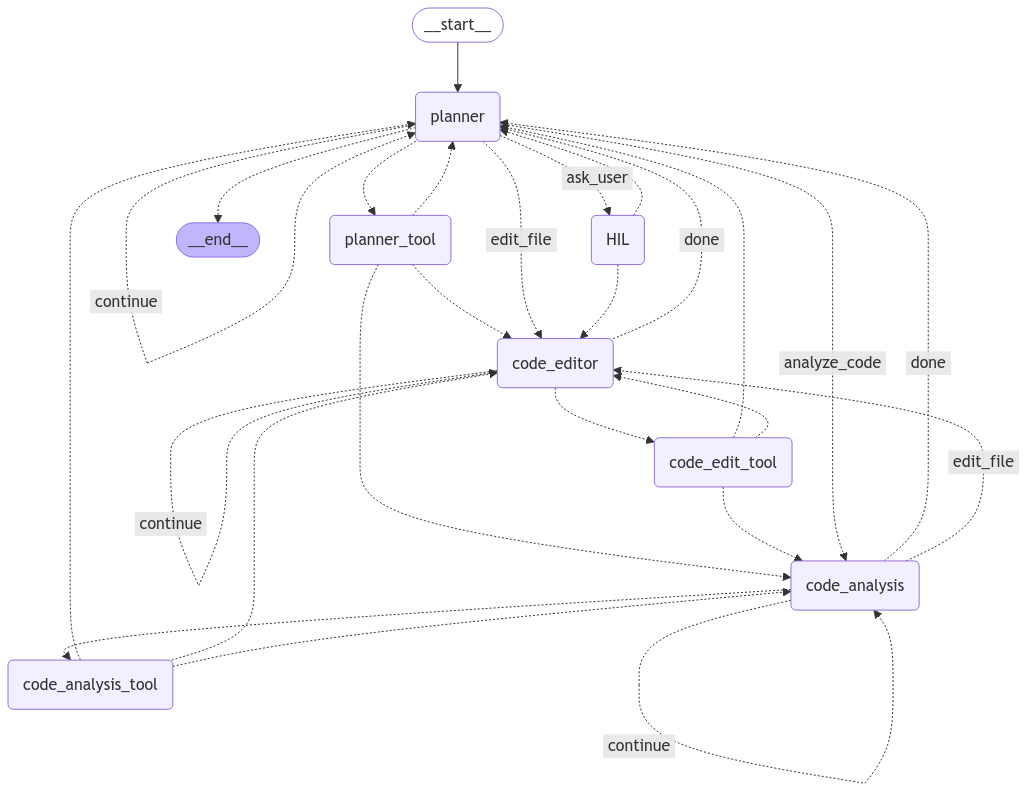

In [88]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [89]:
question = """
There is a bug in the `get_repo_structure.py` file located in the `get_repo_structure` subdirectory. The `clone_repo` function doesnt create a git repo tree and saves it in a txt file, modify it to make it work as expected.
"""
question1 = """
Add a function named `test` in the `testing.py` file located in the `get_repo_structure` subdirectory. The function should take a string as input and return the string in uppercase.
"""
question2 = """
Add a function named `commit_repo` in the `testing.py` file located in the `get_repo_structure` subdirectory. The function should take a commit message as input and execute a git commit with that message.
"""

In [94]:
import time
import pprint
from google.api_core.exceptions import ResourceExhausted

answer = []

# Rate limiting parameters (adjust as needed)
REQUEST_INTERVAL = 1  # Minimum time (seconds) between requests
MAX_RETRIES = 5  # Maximum number of retries
BACKOFF_FACTOR = 2  # Exponential backoff factor

last_request_time = 0  # Initialize the last request time

for step in graph.stream(
    {"messages": [HumanMessage(content=question2)], "sender": "user"}
):
    retries = 0
    while retries < MAX_RETRIES:
        try:
            # Enforce rate limiting
            current_time = time.time()
            elapsed_time = current_time - last_request_time

            if elapsed_time < REQUEST_INTERVAL:
                sleep_duration = REQUEST_INTERVAL - elapsed_time
                time.sleep(sleep_duration)

            answer.append(step)
            # step.pretty_print()
            # print("---")
            for key, value in step.items():
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                pprint.pprint(value, indent=2, width=80, depth=None)
            pprint.pprint("\n---\n")

            # Update last request time
            last_request_time = time.time()
            break  # Exit the retry loop if successful

        except ResourceExhausted:
            retries += 1
            if retries >= MAX_RETRIES:
                print("Max retries reached. Exiting.")
                break
            sleep_duration = BACKOFF_FACTOR ** retries
            print(f"Resource exhausted. Retrying in {sleep_duration} seconds...")
            time.sleep(sleep_duration)

"Output from node 'planner':"
'---'
{ 'messages': [ AIMessage(content=[{'text': 'Let me first check the repository structure to understand the codebase better.', 'type': 'text'}, {'id': 'toolu_01X2RH4NfyQ7RFCJ2NFFjF9w', 'input': {}, 'name': 'get_repo_tree', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01StDjcfPHLt2bcrKyfL9upe', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1493, 'output_tokens': 54}}, name='planner', id='run-44f0d87d-fd30-46d7-851e-9eb058557a1d-0', tool_calls=[{'name': 'get_repo_tree', 'args': {}, 'id': 'toolu_01X2RH4NfyQ7RFCJ2NFFjF9w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1493, 'output_tokens': 54, 'total_tokens': 1547, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})],
  'sender': 'planner'}
'\n---\n'
"Output from node 'planner_tool':"
'---'
{ 'messages': [ ToolMessage(conten

In [91]:
answer[5]['code_analysis']['messages'][0].name

'code_analysis'

In [92]:
# code_match = re.search(r'```(?:python)?\n(.*?)```', mess.content, re.DOTALL)
# if code_match:
#     proposed_changes = code_match.group(1).strip()
# proposed_changes